# Bayesian Toy Regression for Posterior Learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from scipy.stats import norm

#torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [2]:
FONTSIZE = 18

# Try LaTeX settings, fall back gracefully
try:
    if shutil.which("latex") is not None:
        plt.rc("text", usetex=True)
        plt.rc(
            "text.latex",
            preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}",
        )
        plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
    else:
        raise RuntimeError("LaTeX not found")
except Exception:
    # Fallback to default matplotlib serif font
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif", size=FONTSIZE)

plt.rc("axes", titlesize="medium")

# Define color cycle
colors = [f"C{i}" for i in range(5)]

In [ ]:
# Get some simple toy function
def generate_data(n_samples, unc=0.2, seed=None):
    """
    Simple 1D regression problem based
    """
    if seed is not None:
        np.random.seed(seed)
    x = np.concatenate((np.random.uniform(-1, -0.22, n_samples // 2), np.random.uniform(0.22, 1, n_samples - n_samples // 2)))
    y = 0.5 * np.sin(23*x) + x/2
    y_noise = y + np.random.randn(n_samples) * unc #* (x+1) + np.random.randn(n_samples) * unc/2
    return x, y_noise

In [4]:
class VBLinear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        prior_prec: float = 1.0,
        map: bool = False,
        std_init: float = -9,
    ):
        super().__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = map
        self.prior_prec = prior_prec
        self.random = None
        self.NBOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
        self.eps = 1e-12 if torch.get_default_dtype() == torch.float64 else 1e-8
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.std_init = std_init
        self.reset_parameters()

    def enable_map(self):
        self.map = True

    def disenable_map(self):
        self.map = False

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def reset_random(self):
        self.random = None
        self.map = False

    def sample_random_state(self):
        return torch.randn_like(self.logsig2_w).detach().cpu().numpy()

    def import_random_state(self, state):
        self.random = torch.tensor(
            state, device=self.logsig2_w.device, dtype=self.logsig2_w.dtype
        )

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(self.NBOUND, 11)
        kl = (
            0.5
            * (
                self.prior_prec * (self.mu_w.pow(2) + logsig2_w.exp())
                - logsig2_w
                - 1
                - math.log(self.prior_prec)
            ).sum()
        )
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = F.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(self.NBOUND, 11)
            s2_w = logsig2_w.exp()
            # Needed to avoid NaNs from gradient of sqrt in next line!
            var_out = F.linear(input.pow(2), s2_w) + self.eps
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map:
                return F.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(self.NBOUND, 11)
            if self.random is None:
                self.random = torch.randn_like(self.mu_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return F.linear(input, weight, self.bias)

    def __repr__(self):
        return f"{self.__class__.__name__} ({self.n_in}) -> ({self.n_out})"

In [5]:
class BayesNet(nn.Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, training_size, hdn_dim=14, layers=2, prior_prec=1.0, n_blayers=1):

        super().__init__()

        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size
        
        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately

        self.vb_layers = []
        self.all_layers = []

        # define the input layer
        linear_layer = nn.Linear(1, hdn_dim)
        #vb_layer = VBLinear(1, hdn_dim, prior_prec=prior_prec)
        #self.vb_layers.append(vb_layer)
        #self.all_layers.append(vb_layer)
        self.all_layers.append(linear_layer)
        self.all_layers.append(nn.GELU())

        # loop over hidden layers
        for i in range(layers):
            if i >= layers-n_blayers+1: 
                vb_layer = VBLinear(hdn_dim, hdn_dim, prior_prec=prior_prec)
                self.vb_layers.append(vb_layer)
                self.all_layers.append(vb_layer)
            else:
                linear_layer = nn.Linear(hdn_dim, hdn_dim)
                self.all_layers.append(linear_layer)
            self.all_layers.append(nn.GELU())

        # define the output layer
        vb_layer = VBLinear(hdn_dim, 2, prior_prec=prior_prec)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)

        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    def reset_random(self):
        """
        Reset the random state of all bayesian layers.
        """
        for vb_layer in self.vb_layers:
            vb_layer.reset_random()

    # and of course the forward function
    def forward(self, x):
        out = self.model(x)
        return out

    # we need the KL from the bayesian layers to compute the loss function
    def KL(self):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size
    
    # let's put the neg_log_gauss in the network class as it is key to bayesian networks
    def neg_log_gauss(self, outputs: torch.Tensor, targets: torch.Tensor):
        mu = outputs[:, 0]
        logsigma2 = outputs[:, 1].clamp(N_BOUND, 11)
        out = 0.5 * ((targets - mu)**2 / logsigma2.exp() + logsigma2)
        return torch.mean(out)

In [6]:
# define training setup
epochs = 1000
batch_size = 200
n_samples = batch_size*10
unc = 0.1
prior = 1.0
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

# Define the model and look at it
trn_len = x_train.shape[0]
hdn_dim = 32
layers = 6 # number of hidden layers
n_blayers = 2 # number of bayesian layers at the end
toy_model = BayesNet(trn_len, hdn_dim=hdn_dim, layers=layers, prior_prec=prior, n_blayers=n_blayers)


# Build dataset
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE), torch.tensor(y_train_scaled, dtype=DTYPE)
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

opt = torch.optim.AdamW(toy_model.parameters(), lr=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

In [7]:
# Train the model
toy_model.train()

for i in range(epochs):
    train_losses = np.array([])
    kl_losses = np.array([])
    for xb, yb in loader:
        
        # pass data through network
        pred = toy_model(xb)
        
        # compute loss
        nl = toy_model.neg_log_gauss(pred, yb)
        kl = toy_model.KL()
        loss = nl + kl
        
        train_losses = np.append(train_losses, loss.item())
        kl_losses = np.append(kl_losses, kl.item())

        # reset gradients in optimizer
        opt.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        opt.step()
        sched.step()
        
    train_losses_epoch = train_losses.mean()
    kl_losses_epoch = kl_losses.mean()

    if i % 100 == 0:
        print(f"epoch={i}, loss={train_losses_epoch:.4f}, kl={kl_losses_epoch:.4f}")

epoch=0, loss=2.6390, kl=2.1774
epoch=100, loss=0.3013, kl=0.7940
epoch=200, loss=-0.6696, kl=0.1869
epoch=300, loss=-0.8287, kl=0.1557
epoch=400, loss=-0.8888, kl=0.1411
epoch=500, loss=-0.9018, kl=0.1314
epoch=600, loss=-0.9201, kl=0.1240
epoch=700, loss=-0.9561, kl=0.1190
epoch=800, loss=-0.9606, kl=0.1163
epoch=900, loss=-0.9762, kl=0.1153


In [8]:
# get 100 different samples from the BNN
N_samp = 100
means = []
sigmas2 = []
xx = np.linspace(-1.2, 1.2, 5000)
toy_model.eval()
for _ in range(N_samp):  # Loop over ensembles
    toy_model.reset_random()
    with torch.no_grad():
        out = toy_model(torch.tensor(xx[:,None], dtype=DTYPE))
        mu = out[:,0]
        sigma2 = out[:,1].clamp(N_BOUND, 11).exp()

    means.append(mu.detach().cpu().numpy())
    sigmas2.append(sigma2.detach().cpu().numpy())

    
mus = np.stack(means, axis=1) * Y_STD + Y_MEAN
sigmas2 = np.stack(sigmas2, axis=1)
sig = np.sqrt(sigmas2) * Y_STD

mean = np.squeeze(mus.mean(axis=1))
std = np.squeeze(mus.std(axis=1))
sigmean = np.squeeze(sig.mean(axis=1))

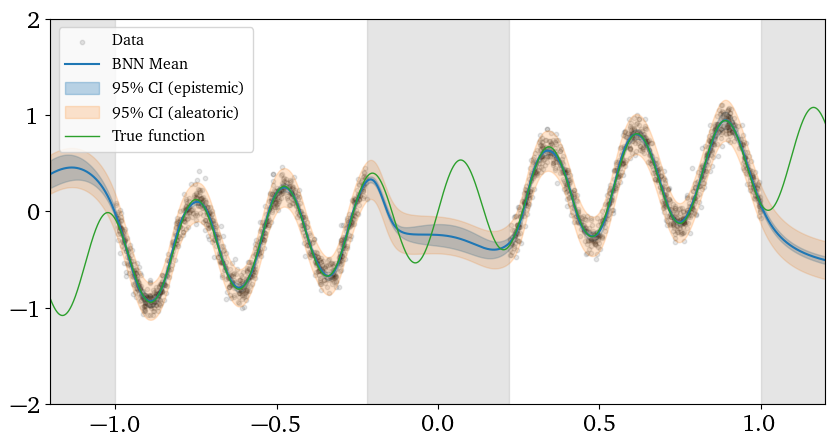

In [13]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train,y_train, s=10, alpha=1/10, label='Data', color="k")
plt.plot(xx, mean, color="C0", label='BNN Mean')
z = norm.ppf(0.975)  # two-sided: (1 + 0.95)/2
lower = mean - z * std
upper = mean + z * std
lower_alea = mean - z * sigmean
upper_alea = mean + z * sigmean
plt.fill_between(xx, lower, upper, alpha=0.3, label=r'95\% CI (epistemic)', color="C0", zorder=-10)
plt.fill_between(xx, lower_alea, upper_alea, alpha=0.2, label=r'95\% CI (aleatoric)', color="C1")
plt.axvspan(-0.22, 0.22, color='gray', alpha=0.2)
plt.axvspan(1, 1.2, color='gray', alpha=0.2)
plt.axvspan(-1.2, -1.0, color='gray', alpha=0.2)
# plot the prediction with unc:
y = 0.5 * np.sin(23*xx) + xx/2
plt.plot(xx, y, color="C2", label='True function', linewidth=1)
plt.legend(fontsize=FONTSIZE-6, loc='upper left')
plt.ylim(-2,2)
plt.xlim(-1.2,1.2)
plt.show()